# OCO-3 Snapshot Area Map (SAM) Exploration

While OCO-2 and OCO-3 use the same set of spectrometers, one development with OCO-3 has been the addition of a Pointing Mirror Assembly (PMA). The PMA allows for rapid changes in the pointing of the instrument, enabling data to be collected over contiguous 80km x 80km areas known as Snapshot Area Maps (SAMs). The science team maintains a repository of SAM acquisitions from throughout the mission on this webpage: [https://ocov3.jpl.nasa.gov/sams/](https://ocov3.jpl.nasa.gov/sams/)

In this notebook, we will look at SAMs acquired at one site in the Cascade Mountains region of the state of Oregon, United States. This region is composed predominantly of ponderosa pine trees and cedars with a sparse understory; vegetation cover is about 60%. By comparing SAM acquisitions over time, we can observe the seasonal changes in SIF for this ecoregion, as well as the changes due to disruption. As we will see later in the exercise, a major fire burned through this region in August 2020. Additionally, there is a [FLUXNET eddy covariance tower](https://ameriflux.lbl.gov/sites/siteinfo/US-Me2) located within the boundaries of this site that can be used as a "ground truth" comparison to the values we observe with OCO-3.

In [2]:
import contextily as ctx
from cartopy import crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# Add src directory containing helper code to sys.path
sys.path.append(os.path.abspath("../src"))

from pysif import GesDiscDownloader, plot_samples

## I. Retrieving SAM Data

The [SAM webpage](https://ocov3.jpl.nasa.gov/sams/index.php) mentioned previously is a great place to start for finding specific sites and observations. In this exercise, we will be looking specifically at the `ecostress_us_me2` site, but you can pan through the map on the webpage to find a different area of interest on your own. If you put this site name and the site type ("SIF_Low", which can be found by clicking on the map pin for the site) into the search parameters, a list of all SAM observations at that site will be pulled up.  

<div align="center">
  <img src="images/ecostress_us_me2_map.png" alt="ecostress_us_me2 map pin">
</div>

These search results can tell us which dates we want to retrieve SIF granules for, and then filter those granules to only include soundings from the SAM mode, which is mode 2 in the granule. The retrieval itself can use the same code from the exploration notebook from earlier. To start let"s take the first SAM observation with a non-zero amount of soundings, which we can see from the search results occurred on May 28th, 2020:

<div align="center">
  <img src="images/sam_search_result.png" alt="SAM mode search result">
</div>

In [3]:
dl = GesDiscDownloader()

dataset = "OCO3_L2_Lite_SIF.11r"
data_date = datetime(2020, 5, 28)
granule = dl.get_granule_by_date(dataset, data_date)

Checking available dates on GES DISC for OCO3_L2_Lite_SIF.11r


Now that we have the granule, we can filter the data to just SAM soundings. You can find more information about OCO-3"s measurement modes in the [User"s Guide](https://docserver.gesdisc.eosdis.nasa.gov/public/project/OCO/OCO2_v11.2_OCO3_v11_SIF_Data_Users_Guide.pdf), see Section 4.7 "The Metadata Group". Measurement Mode 3 is referred to as an AreaMap -- this is the SAM mode we are interested in.

In [ ]:
# Get the measurement mode of the data first so we can filter to just use SAM mode soundings
# Additionally, we will remove low quality soundings
meas_mode = np.array(granule["Metadata_MeasurementMode"].data[:])
qual_flag = np.array(granule["Quality_Flag"].data[:])
sam_mask  = (meas_mode == 3) & ((qual_flag == 0) | (qual_flag == 1))

all_lat = granule["Latitude"].data[:]
all_lon = granule["Longitude"].data[:]
all_sif = granule["Daily_SIF_757nm"].data[:]

lat = all_lat[sam_mask]
lon = all_lon[sam_mask]
sif = all_sif[sam_mask]

sam_extent = [-123.9, -120.4, 43.3, 45]
# sam_extent = [-122.6, -120.4, 44, 45.7]

# Using the plot_samples function from the first notebook gives us a good first look at this data
# before further processing. The YlGn colormap is used to make it easier to compare the data with
# the official plot.
plot_samples(
    sif, lat, lon,
    vmin=-0.05,
    vmax=0.55,
    cmap="YlGn",
    point_size=15,
    fig_size=(8, 8),
    extents=sam_extent,
    title=f"OCO-3 SAM mode LtSIF 757 nm ({data_date.strftime('%Y-%m-%d')})",
    label=r"Daily SIF 757 nm (W/$\mathrm{m}^2$/sr/μm)"
)

### Comparison with official plot
If you've been following along on the OCO-3 website, you may have noticed that the science team provides pre-made plots of a variety of measurements for each SAM acquisition. Let's take a look at one of these plots for the OCO-3 LtSIF 757nm variable:

<div style="text-align:center">
  <img style="width:640px" src="images/OCO3_Lite_B11074Ar_r02_sif_757nm_20200528_6040_ecostress_us_me2.png" alt="Official OCO-3 SAM mode plot for May 28, 2020">
</div>

If the previous code ran successfully for you, you should be able to see that our plot is already comparable to the official one and that we are at least looking at the same data but with some superficial differences in presentation. In the next section, we will refine our plot to look like the official version. The most important component of this will be to adjust each sounding to use its proper footprint extents.

In [ ]:
all_footlat = granule["Geolocation_footprint_latitude_vertices"].data[:]
all_footlon = granule["Geolocation_footprint_longitude_vertices"].data[:]
footprint_lat = all_footlat[sam_mask][:]
footprint_lon = all_footlon[sam_mask][:]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.GOOGLE_MERCATOR)

ax.set_extent(sam_extent, crs=ccrs.PlateCarree())

patches_list = []
for i in range(len(sif)):
    polygon = patches.Polygon(np.column_stack([footprint_lon[i], footprint_lat[i]]))
    patches_list.append(polygon)

pcol = PatchCollection(
    patches_list,
    cmap="YlGn",
    transform=ccrs.PlateCarree()
)

pcol.set_array(np.array(sif))
pcol.set_clim(-0.01, 0.55)
sif_layer = ax.add_collection(pcol)

ctx.add_basemap(
    ax,
    source=ctx.providers.Esri.WorldImagery,
    crs=ccrs.GOOGLE_MERCATOR,
    zoom=9
)

# Add gridlines over the map. Note that we can use the default LATITUDE_FORMATTER and
# LONGITUDE_FORMATTER from cartopy to make our lives easier
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="white", alpha=0.7, linestyle="-")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 14, "color": "black"}
gl.ylabel_style = {"size": 14, "color": "black"}

plt.title(f"OCO-3 SAM mode LtSIF 757 nm ({data_date.strftime("%Y-%m-%d")})", fontsize=16)
cbar = plt.colorbar(sif_layer, ax=ax, extend="both", pad=0.01)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Daily SIF 757 nm [W/$\mathrm{m}^2$/sr/μm]", fontsize=16, rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

## II. Comparison of OCO-3 SIF with Ameriflux Tower GPP Data

In this section, we will compare daily averaged SIF from OCO-3 against tower GPP data from the US-Me-2 site. Ultimately, we will create a daily time-scale plot comparing available data from the two datasets over the period from August 2019 (the beginning of the OCO-3 mission) through the end of 2022 (the end of the Ameriflux data for this tower as of the writing of this training). This plot will look similar to figure 3b from [Pierrat et al., 2022](https://doi.org/10.1029/2021JG006588).

### Pre-processing

Several pre-processing steps have already been taken for you. First, you will notice there is an ancillary file called "us_me2_oco3_dates.json" in the same directory as this notebook. This JSON file was created by studying all available data dates across the OCO-3 mission from August 2019 - December 2022 to determine when soundings within a 0.5-degree radius around the tower site were acquired, and to store the relevant locations within the granule that those soundings occurred. This search process was performed using the code sample in the Appendix notebook, so we will just discuss it conceptually here. By looping through each date in the time range of interest, we can search for (longitude, latitude) coordinate pairs that lie within the defined bounding box: in this case, $\pm 0.25^{\circ}$ around the tower coordinates. In the next part of the pre-processing, we extract the relevant data from each discovered granule and take the mean of all 757nm SIF data with a Quality Flag value of 0 (best) or 1 (good). The spatial means are stored in a separate JSON file that will be used as the basis for our daily SIF values in the comparison plot.

The tower GPP data itself can be found by using the "Download Data" functionality on the [Ameriflux page for the tower](https://ameriflux.lbl.gov/sites/siteinfo/US-Me2), but you need your own account to do this yourself. The Ameriflux data is presented at several time scales ranging from yearly to hourly, but for this analysis we are just using the daily data. An abridged version of the daily data is included in the notebooks directory containing just the entries for August 2019 through the end of 2022.

Loading SIF data...
Loading GPP data...
Merging datasets...
Creating scatter plot...
Number of matched data points: 69
Linear regression equation: y = 7.658x + 1.010
R² value: 0.094
Slope: 7.658
Intercept: 1.010


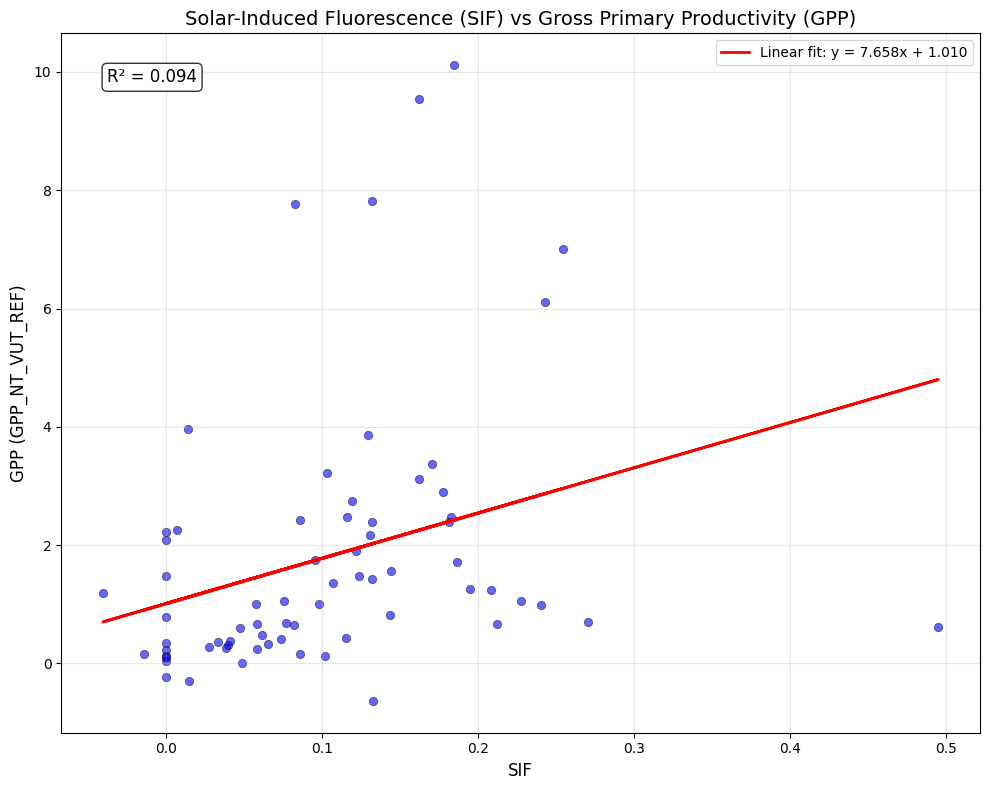

In [ ]:
import json
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def load_sif_data(json_file):
    """Load SIF data from JSON file"""
    with open(json_file, "r") as f:
        data = json.load(f)
    
    # Convert to DataFrame
    df = pd.DataFrame(data["dates"])
    df["date"] = pd.to_datetime(df["date"])
    return df

def load_gpp_data(csv_file, gpp_column="GPP_NT_VUT_REF"):
    """Load GPP data from CSV file"""
    # Read CSV
    df = pd.read_csv(csv_file)
    
    # Convert TIMESTAMP to datetime
    df["date"] = pd.to_datetime(df["TIMESTAMP"], format="%Y%m%d")
    
    # Select relevant columns
    df = df[["date", gpp_column]].copy()
    df.rename(columns={gpp_column: "gpp"}, inplace=True)
    
    return df

def merge_and_clean_data(sif_df, gpp_df):
    """Merge SIF and GPP data on date and remove invalid values"""
    # Merge on date
    merged = pd.merge(sif_df, gpp_df, on="date", how="inner")
    
    # Remove rows with NaN or negative values
    merged = merged.dropna()
    
    # Remove rows where GPP is the fill value, -9999
    merged = merged[merged["gpp"] != -9999]
    
    return merged

def create_scatter_plot(data, gpp_column_name="GPP_NT_VUT_REF"):
    """Create scatter plot with linear regression"""
    # Extract x and y values
    x = data["sif"].values.reshape(-1, 1)
    y = data["gpp"].values
    
    # Fit linear regression
    reg = LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(x)
    
    # Calculate R²
    r2 = r2_score(y, y_pred)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Scatter plot
    plt.scatter(x, y, alpha=0.6, color="blue", edgecolors="black", linewidth=0.5)
    
    # Regression line
    plt.plot(x, y_pred, color="red", linewidth=2, 
             label=f"Linear fit: y = {reg.coef_[0]:.3f}x + {reg.intercept_:.3f}")
    
    # Add R² value to plot
    plt.text(0.05, 0.95, f"R² = {r2:.3f}", 
             transform=plt.gca().transAxes, 
             fontsize=12, 
             verticalalignment="top",
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    
    # Labels and title
    plt.xlabel(r"SIF [W/$\mathrm{m}^2$/sr/μm]", fontsize=12)
    plt.ylabel(f"GPP ({gpp_column_name}) " + r"[gC/$\mathrm{m}^2/day]", fontsize=12)
    plt.title("Solar-Induced Fluorescence (SIF) vs Gross Primary Productivity (GPP)", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Print statistics
    print(f"Number of matched data points: {len(data)}")
    print(f"Linear regression equation: y = {reg.coef_[0]:.3f}x + {reg.intercept_:.3f}")
    print(f"R² value: {r2:.3f}")
    print(f"Slope: {reg.coef_[0]:.3f}")
    print(f"Intercept: {reg.intercept_:.3f}")
    
    plt.tight_layout()
    plt.show()


# File paths
sif_file = "us_me2_oco3_sif.json"
gpp_file = "AMF_US-Me2_FLUXNET_SUBSET_DD_2019-2022_4-6.csv"

# Configurable GPP column
gpp_column = "GPP_NT_VUT_REF"  # Change this to use a different GPP column

try:
    sif_data = load_sif_data(sif_file)
    
    gpp_data = load_gpp_data(gpp_file, gpp_column)
    
    merged_data = merge_and_clean_data(sif_data, gpp_data)
    
    create_scatter_plot(merged_data, gpp_column) 
except FileNotFoundError as e:
    print(f"Error: File not found - {e}")
except Exception as e:
    print(f"Error: {e}")
